In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from geobr import read_municipality
from pathlib import Path

In [14]:
# Municípios do Paraná
gdf_pr = read_municipality(code_muni="PR", year=2020)

print("Tipo:", type(gdf_pr))
print("Número de linhas:", len(gdf_pr))
print("\nColunas do gdf_pr:")
print(gdf_pr.columns)

print("\nPrimeiras linhas:")
print(gdf_pr.head())

Tipo: <class 'geopandas.geodataframe.GeoDataFrame'>
Número de linhas: 399

Colunas do gdf_pr:
Index(['code_muni', 'name_muni', 'code_state', 'abbrev_state', 'name_state',
       'code_region', 'name_region', 'geometry'],
      dtype='object')

Primeiras linhas:
   code_muni            name_muni  code_state abbrev_state name_state  \
0  4100103.0               Abatiá        41.0           PR     Paraná   
1  4100202.0         Adrianópolis        41.0           PR     Paraná   
2  4100301.0        Agudos Do Sul        41.0           PR     Paraná   
3  4100400.0  Almirante Tamandaré        41.0           PR     Paraná   
4  4100459.0   Altamira Do Paraná        41.0           PR     Paraná   

   code_region name_region                                           geometry  
0          4.0         Sul  MULTIPOLYGON (((-50.22465 -23.22603, -50.22826...  
1          4.0         Sul  MULTIPOLYGON (((-48.99969 -24.63712, -49.00061...  
2          4.0         Sul  MULTIPOLYGON (((-49.30433 -25.9

In [18]:
from pathlib import Path

caminho_sidra = Path("Soja2023.csv")

with open(caminho_sidra, "r", encoding="latin1") as f:
    for i in range(10):
        linha = f.readline()
        print(f"{i+1:02d}: {repr(linha)}")

01: 'ï»¿"Tabela 5457 - Ã\x81rea plantada ou destinada Ã\xa0 colheita, Ã¡rea colhida, quantidade produzida, rendimento mÃ©dio e valor da produÃ§Ã£o das lavouras temporÃ¡rias e permanentes"\n'
02: '"VariÃ¡vel - Quantidade produzida (Toneladas)"\n'
03: '"MunicÃ\xadpio";"Ano x Produto das lavouras temporÃ¡rias e permanentes"\n'
04: '"MunicÃ\xadpio";"2023"\n'
05: '"MunicÃ\xadpio";"Total";"Soja (em grÃ£o)"\n'
06: '"Alta Floresta D\'Oeste (RO)";"..";"4824"\n'
07: '"Ariquemes (RO)";"..";"46230"\n'
08: '"Cabixi (RO)";"..";"100000"\n'
09: '"Cacoal (RO)";"..";"16420"\n'
10: '"Cerejeiras (RO)";"..";"140000"\n'


In [19]:
df_raw = pd.read_csv(
    "Soja2023.csv",
    sep=";",
    header=None,        
    skiprows=5,         # pula as 5 linhas de metadados
    encoding="utf-8-sig"
)

print(df_raw.head())
print(df_raw.shape)

                            0   1       2
0  Alta Floresta D'Oeste (RO)  ..    4824
1              Ariquemes (RO)  ..   46230
2                 Cabixi (RO)  ..  100000
3                 Cacoal (RO)  ..   16420
4             Cerejeiras (RO)  ..  140000
(5585, 3)


In [21]:
# Copiamos o df
df = df_raw.copy()

# Coluna original de município+UF
df["mun_uf"] = df[0]

# Extrai a UF que está entre parênteses no final
df["uf"] = df["mun_uf"].str.extract(r"\((..)\)$")[0]

# Extrai só o nome do município
df["nome_mun"] = df["mun_uf"].str.replace(r"\s*\(..\)$", "", regex=True)

# Mantém só as colunas que interessam 
df = df[["nome_mun", "uf", 2]]

# Renomeia a coluna 2
df = df.rename(columns={2: "soja_producao_bruta"})

print("Formato do df:", df.shape)
print("\nPrimeiras linhas do df:")
print(df.head())

# Filtra só Paraná
df_pr_soja = df[df["uf"] == "PR"].copy()

print("\nFormato do df_pr_soja:", df_pr_soja.shape)
print("\nPrimeiras linhas de df_pr_soja:")
print(df_pr_soja.head())

Formato do df: (5585, 3)

Primeiras linhas do df:
                nome_mun  uf soja_producao_bruta
0  Alta Floresta D'Oeste  RO                4824
1              Ariquemes  RO               46230
2                 Cabixi  RO              100000
3                 Cacoal  RO               16420
4             Cerejeiras  RO              140000

Formato do df_pr_soja: (399, 3)

Primeiras linhas de df_pr_soja:
                 nome_mun  uf soja_producao_bruta
3905               Abatiá  PR               35856
3906         Adrianópolis  PR                  70
3907        Agudos do Sul  PR                6888
3908  Almirante Tamandaré  PR                 629
3909   Altamira do Paraná  PR                8750


In [22]:
print("Colunas de gdf_pr:")
print(gdf_pr.columns)

print("\nPrimeiras linhas de gdf_pr:")
print(gdf_pr[["code_muni", "name_muni"]].head())

Colunas de gdf_pr:
Index(['code_muni', 'name_muni', 'code_state', 'abbrev_state', 'name_state',
       'code_region', 'name_region', 'geometry'],
      dtype='object')

Primeiras linhas de gdf_pr:
   code_muni            name_muni
0  4100103.0               Abatiá
1  4100202.0         Adrianópolis
2  4100301.0        Agudos Do Sul
3  4100400.0  Almirante Tamandaré
4  4100459.0   Altamira Do Paraná


Juntando os dois datasets: 

In [23]:
import unicodedata

def normalizar_nome(s):
    if pd.isna(s):
        return s
    s = str(s).strip().lower()
    # remover acentos
    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c))
    # trocar alguns caracteres problemáticos
    s = s.replace("-", " ")
    s = s.replace("'", " ")
    s = " ".join(s.split())
    return s

# normaliza nomes nos dois dataframes
gdf_pr["nome_norm"] = gdf_pr["name_muni"].apply(normalizar_nome)
df_pr_soja["nome_norm"] = df_pr_soja["nome_mun"].apply(normalizar_nome)

# garante que a produção é numérica
df_pr_soja["soja_producao"] = pd.to_numeric(
    df_pr_soja["soja_producao_bruta"],
    errors="coerce"
)

# faz o merge pelo nome normalizado
gdf_merged = gdf_pr.merge(
    df_pr_soja[["nome_norm", "soja_producao"]],
    on="nome_norm",
    how="left"
)

print("Linhas em gdf_merged:", len(gdf_merged))
print("Municípios do PR sem dado de soja (NaN):", gdf_merged["soja_producao"].isna().sum())

print("\nExemplo de linhas após merge:")
print(gdf_merged[["name_muni", "soja_producao"]].head())

Linhas em gdf_merged: 399
Municípios do PR sem dado de soja (NaN): 9

Exemplo de linhas após merge:
             name_muni  soja_producao
0               Abatiá        35856.0
1         Adrianópolis           70.0
2        Agudos Do Sul         6888.0
3  Almirante Tamandaré          629.0
4   Altamira Do Paraná         8750.0


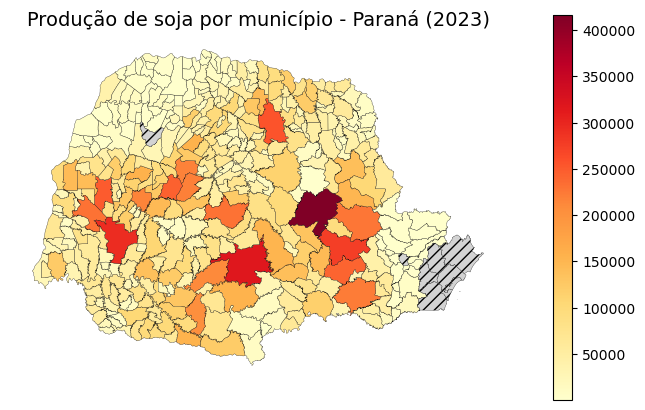

In [ ]:


fig, ax = plt.subplots(figsize=(8, 10))

# plota e captura o objeto mappable
mappable = gdf_merged.plot(
    column="soja_producao",
    ax=ax,
    legend=True,
    cmap="YlOrRd",
    edgecolor="black",
    linewidth=0.2,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "///",
        "label": "Sem dado de soja",
    },
)

ax.set_title("Produção de soja por município - Paraná (2023)", fontsize=14)
ax.axis("off")

# Ajusta a colorbar
cbar = ax.get_figure().axes[-1]  # a colorbar é o último eixo criado

# Ajustar largura da colorbar
pos = cbar.get_position()
cbar.set_position([pos.x0 + 0.02, pos.y0, pos.width * 0.5, pos.height])

plt.show()